<a href="https://colab.research.google.com/github/haohe1113/lift-analysis-on-car-brands/blob/main/lift_analysis_on_car_brand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The forum we used: https://forums.edmunds.com/discussion/7526/general/x/midsize-sedans-2-0

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/lift_analysis_on_car_brands/'

Mounted at /content/drive
/content/drive/MyDrive/lift_analysis_on_car_brands


## Section A: Lift Analysis on Car Brands
In this section, we will identify the top 10 mostly  mentioned brands by consumers from the UGC we just scraped. Then, we will calculate lift ratios for associations between each pair of the top 10 brands and present a lift table. We *will* also visualize the lift table by a MDS map. 

### Data Preprocessing

In [3]:
import nltk
import pandas as pd
import numpy as np
nltk.download("stopwords")
nltk.download("punkt")
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
stop = stopwords.words('english')

# define the reference table to replace models with brands
reference = pd.read_csv("car models and brands.csv", names = ["Brand","Model"],header = None)
reference.set_index(reference["Model"],inplace = True)
reference["Model"].drop_duplicates(inplace = True)

models = reference["Model"].tolist()
brands = reference["Brand"].tolist()


"""
This function takes the message and splits it into words, using regular expressions to match cases.  
The regular expression is r'\w+'.  The r converts the message into a string literal (disregarding \n)
and then finds all words in the message.
"""
def filter(series):
  filtered_messages = []
  for i in range(len(series)):
    current_message = series.iloc[i]
    tokenizer = RegexpTokenizer(r'\w+')
    words = tokenizer.tokenize(current_message)
    edited_list = words.copy()
    for j in words:
      current_word = j.lower()
      if current_word in stop:
        edited_list.remove(j)
    filtered_messages.append(edited_list)
  return filtered_messages

"""
This function takes a 2D list and removes "models" in each row and replaces them with "brands"
"""

def remove_models(somelist):
  newlists = []
  for i in range(len(somelist)):
    for j in range(len(somelist[i])):
      somelist[i] = [x.lower() for x in somelist[i]]
      current_word = somelist[i][j].strip()
      if current_word in models:
        somelist[i][somelist[i].index(current_word)] = reference["Brand"].loc[reference["Model"] == current_word].values[0].title()
    newlists.append(somelist[i])
  return newlists

"""
This function takes a 2D list and removes duplicated brands within each row.
"""
def remove_duplications(somelist):
  newlists = []
  for i in range(len(somelist)):
    copy_oflist = somelist[i].copy()
    copy_oflist = [x.lower() for x in copy_oflist]
    repeat_catcher = []
    for j in range(len(somelist[i])):
      current_word = somelist[i][j].lower().strip()
      if current_word in brands:
        if current_word in repeat_catcher:
          copy_oflist.remove(current_word)
        else:
          repeat_catcher.append(current_word)
    newlists.append(copy_oflist)
  return newlists

"""
This function takes a 2D list and counts the total number of times a particular word was used
across all rows.
"""

def freq(somelist):
  frequency_counts = {}
  for i in range(len(somelist)):
    for j in range(len(somelist[i])):
      current_word = somelist[i][j].lower()
      if current_word not in frequency_counts:
        frequency_counts[current_word] = 1
      else:
        frequency_counts[current_word] += 1
  return frequency_counts

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
df2 = pd.read_csv("results.csv")
df2 = df2["Message"].map(str)
count_dict = freq(remove_duplications(remove_models(filter(df2))))

In [5]:
count_data = pd.DataFrame(list(count_dict.items()),columns = ["Word","Count"]).sort_values(by = "Count", ascending = False)
# write to csv

count_data.to_csv("total_data_counts.csv", index = False)

In [6]:
relevant_count_data = pd.DataFrame(columns = ["Word","Count"])

for i in range(len(count_data)):
  if count_data["Word"].iloc[i] in brands:
    relevant_count_data.loc[len(relevant_count_data)] = [count_data["Word"].iloc[i],count_data["Count"].iloc[i]]

# remove extra words
relevant_count_data = relevant_count_data[relevant_count_data["Word"] != "problem"]
relevant_count_data = relevant_count_data[relevant_count_data["Word"] != "car"]
relevant_count_data = relevant_count_data[relevant_count_data["Word"] != "sedan"]
relevant_count_data = relevant_count_data[relevant_count_data["Word"] != "seat"]

In [7]:
relevant_count_data.to_csv("car_data_counts.csv",index = False)

In [8]:
# Some preprocessing.  We can see that the top 10 cars by frequency are as follows

relevant_count_data = pd.read_csv("car_data_counts.csv")

top_10 = relevant_count_data.iloc[:10].copy()
print(top_10)
car_names = top_10["Word"].tolist()
car_counts = top_10["Count"].tolist()
total = len(df2)

# only run this line once, because we are changing Counts in place
top_10["Count"] = top_10["Count"]/total

        Word  Count
0      honda   2121
1       ford   1398
2     toyota   1007
3    hyundai    627
4      mazda    596
5     nissan    589
6     saturn    259
7  chevrolet    250
8   chrysler    237
9     subaru    165


In [9]:
# We split messages into words in order to find the lifts
splitted_messages = remove_duplications(remove_models(filter(df2)))

### Lift Table

In [32]:
"""
This function extracts the car names from messages only if the car
is within the top 10 frequencies (as defined by the reference list).
"""
def filter_top10_cars(somelist,reference_list):
  newlist = []
  for i in range(len(somelist)):
    current_cars = []
    for j in range(len(somelist[i])):
        if somelist[i][j] in reference_list:
          current_cars.append(somelist[i][j])
    newlist.append(current_cars)
  return newlist

"""
This function calculates the probability of A intersect B, where A 
is one unique car and B is another.
"""
def prob_of_intersect(somelist):
  associations = {}
  for i in range(len(somelist)):
    if len(somelist[i]) > 1:
      current_message = somelist[i]
      for j in range(len(current_message)):
        for k in range(j,len(current_message)):
          if current_message[j] != current_message[k]:
            current_assocV1 = str(current_message[j]) + "," + str(current_message[k])
            current_assocV2 = str(current_message[k]) + "," + str(current_message[j])
            if current_assocV1 in associations:
              associations[current_assocV1] += 1
            elif current_assocV2 in associations:
              associations[current_assocV2] += 1
            else:
              associations[current_assocV1] = 1
  total = len(df2)
  for i in associations:
    associations[i] = associations[i]/total
  return associations

"""
This function calculates the lift based on the intersection values 
found in the previous function.  It divides the probabilities by 
P(A)*P(B), which are found in the data parameter.
"""
def lift_matrix(somedict,data):
  newdict = somedict.copy()
  datatable = pd.DataFrame(columns = ["Car1","Car2","Lift"])
  for i in somedict:
    words = i.strip().split(",")
    car1 = words[0]
    car2 = words[1]

    prob_car1 = data["Count"].loc[data["Word"] == car1].values[0]
    prob_car2 = data["Count"].loc[data["Word"] == car2].values[0]

    denominator = prob_car1*prob_car2

    newdict[i] = somedict[i]/denominator

    datatable.loc[len(datatable)] = [car1,car2,newdict[i]]
    
    matrix = pd.crosstab(datatable["Car1"],datatable["Car2"],values = datatable["Lift"],aggfunc = sum)
    matrix = matrix.fillna(0)
  return matrix

"""
This function takes the matrix returned from the previous problem and converts it into 
an upper-traingular matrix (with diag(matrix) = 0).  The rows and columns must be 
specified.
"""
def upper_triangular(sometable,row,columns):
  for i in range(row):
    for j in range(columns):
      if i > j  and sometable.iloc[i][j] != 0:
       sometable.iloc[j][i] = sometable.iloc[i][j]
       sometable.iloc[i][j] = 0
  sometable.replace([0],value = "",inplace=  True)
  return sometable

lifts = upper_triangular(lift_matrix(prob_of_intersect(filter_top10_cars(splitted_messages,reference_list = car_names)),data = top_10),10,10)
lifts

Car2,chevrolet,chrysler,ford,honda,hyundai,mazda,nissan,saturn,subaru,toyota
Car1,,,,,,,,,,
chevrolet,,2.17215,1.28884,1.30693,1.70526,0.996644,2.01698,5.58069,1.68,1.80894
chrysler,,,1.40436,1.28999,1.66556,0.806006,1.34749,1.3709,1.01266,1.28594
ford,,,,1.19027,1.23673,1.26541,1.24438,1.32608,0.922747,1.45569
honda,,,,,1.45165,1.14341,1.45417,1.3336,1.34371,1.72428
hyundai,,,,,,1.2054,1.62184,1.73745,1.91388,1.88941
mazda,,,,,,,1.46648,1.12235,3.27181,0.964973
nissan,,,,,,,,2.85544,2.08829,2.24498
saturn,,,,,,,,,1.73745,2.31545
subaru,,,,,,,,,,1.28103


In [14]:
lifts.to_csv("lifts.csv")

### Visualize Lift Table by MDS Map

In [33]:
#https://scikit-learn.org/stable/auto_examples/manifold/plot_mds.html#sphx-glr-auto-examples-manifold-plot-mds-py
# ONLY RUN ONCE DUE TO CHANGES IN PLACE

from sklearn.manifold import MDS
pd.options.mode.chained_assignment = 'warn'

def dissimilarity_matrix(sometable,row,columns):
  newtable = sometable.copy()
  for i in range(row):
    for j in range(columns):
      if i < j:
        dis = 1/sometable.iloc[i][j]
        newtable.iloc[i,j] = dis
      elif i > j:
        newtable.iloc[i,j] = newtable.iloc[j,i]
      else:
        newtable.iloc[i,j] = 0
  return newtable

#lift_df = pd.DataFrame(lifts)
lift_simil = dissimilarity_matrix(lifts,10,10)
lift_simil


In [34]:
matrix = lift_simil.values
embedding = MDS(2,random_state = 1)

# Assuming that the embedding prints each car in order
reduced = embedding.fit_transform(matrix)
coordinates = pd.DataFrame(reduced,columns = ["x","y"])
coordinates["Car"] = lifts.index  

/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


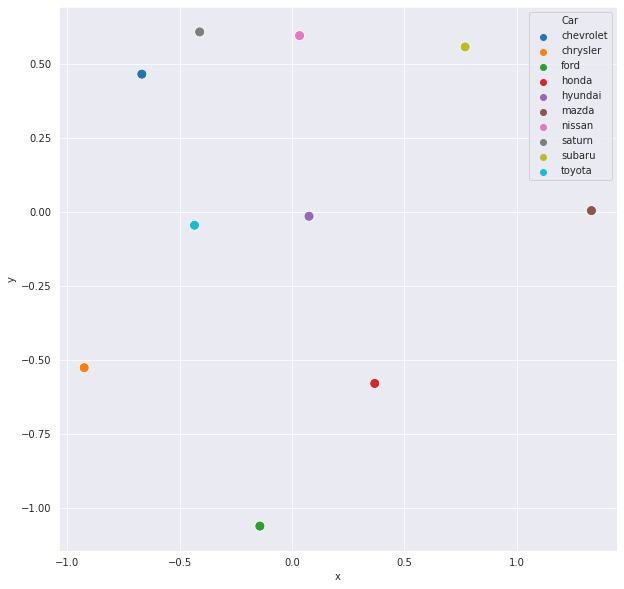

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

fig_dims = (10,10)
fig, axis = plt.subplots(figsize = fig_dims)

sns.set_style("darkgrid")
sns.scatterplot(data = coordinates, x = "x", y = "y",hue = "Car",ax = axis, s = 100)

### Insights

Assuming that our brand manager works at Saturn, we can show that there is a high lift between Saturn and Chevrolet.  Based on the comments in the forum, they are usually being compared as similar cars.  However, in the United States, Saturn cars are generally not popular in comparison to Chevrolet cars.  Given this, the brand manager could make the brand more popular by hiring celebrities to show off their vehicles.  

If, on the other hand, our brand manager is from Chevrolet, we can show that the cars are being compared too similarly.  Given the reputation of Chevrolet, it seems as though the brand manager is doing a good job of marketing Chevrolet.  It may still be useful, however, to bring up the fact that the Saturn Aura is being compared with the Chevrolet Malibu at the same level. 

## Section B: Car Attribute Analysis
In this section, we will identify the attributes that are strongly associated with the polular brands, based on that, we will provide marketing and product-managing advice to each popular brand.




### Data Preprocessing

In [36]:
tokenizer = RegexpTokenizer(r'\w+')
stop = stopwords.words('english')
#raw comments
thread = pd.read_csv('results.csv', header = 0)

#model-brand reference
model_brand = pd.read_csv("car models and brands.csv", 
                          names = ["Brand","Model"],
                          header = None,
                          index_col = "Model")

#data cleaning
#remove puctuation marks from model names and brand names
model_brand['Brand'] = model_brand.Brand.str.replace(r'[^\w\s]', '')
model_brand.index = model_brand.index.str.replace(r'[^\w\s]', '')
#remove duplicated model names
model_brand = model_brand.groupby(model_brand.index).first()
#convert to a dictionary
model_brand_dict = model_brand.to_dict()

thread["Message"] = thread["Message"].astype(str)
#tokenize comments
thread['tokens'] = thread.Message.apply(lambda each_comm: tokenizer.tokenize(each_comm.lower()))
#drop stopwords from tokens
thread['tokens'] = thread.tokens.apply(lambda each_token: [i for i in each_token if i not in stop])
#replace model name tokens by brand names
thread['tokens'] = thread.tokens.apply(lambda each_token: [i if i not in model_brand.index else model_brand.Brand.loc[i] 
                                                           for i in each_token])
#make token list unique
thread['tokens'] = thread.tokens.apply(lambda each_token: list(set(each_token)))

thread[:5]

,UserID,Date,Message,tokens
0,motownusa,"April 11, 2007 7:52PM",Hi Pat:\n\nYou forgot the Chrysler Sebring,"[forgot, pat, hi, chrysler]"
1,exshoman,"April 11, 2007 8:33PM",I'm sure some folks would appreciate having th...,"[would, sure, included, well, appreciate, folk..."
2,targettuning,"April 12, 2007 7:51AM",You can try to revive this topic but without b...,"[comparisons, talk, members, however, manufact..."
3,pat,"April 12, 2007 9:43AM",Model vs. model is exactly what we're here for...,"[turning, time, noted, many, around, manufactu..."
4,perna,"April 13, 2007 12:49PM",The Altima is my favorite of the bunch. It is ...,"[gadgets, like, one, kia, priced, nissan, feel..."


We manually selected car attributes from the list of nouns and adjectives and ended up having about 200 raw attributes. Clustered the attributes with similar meanings and ended up with 20 attribute groups.  We used this dataset (attr_50freq_grouped.csv) for the code below.  If needed, we can provide this dataset.

In [38]:
from nltk import pos_tag
from nltk import FreqDist
nltk.download('averaged_perceptron_tagger')


#pos_tag tokens
thread['token_pos_tag'] = thread.tokens.apply(lambda each_token: pos_tag(each_token))
#filter nouns from tokens
thread['nn_adj'] = thread.token_pos_tag.apply(lambda tag_list: 
                                             [tag[0] for tag in tag_list if tag[1] in ('NN', 'NNS', 'NNP', 'NNPS', 'JJR', 'JJ', 'JJS')])

#token freqency
all_tokens = thread.tokens.sum()
token_freq = pd.Series(dict(nltk.FreqDist(all_tokens))).to_frame(name = 'freq')

#unique noun & adj df
unique_nn_adj = thread.nn_adj.apply(pd.Series).stack().unique()
unique_nn_adj_df = pd.DataFrame(unique_nn_adj, columns = ['nn_adj'])

#noun & adj freq count
nn_adj_freq = unique_nn_adj_df.merge(token_freq, how = 'left', left_on = 'nn_adj',right_index = True).\
                               set_index('nn_adj')['freq'].\
                               sort_values(ascending = False).\
                               to_frame()
#keep items with >50 frequency
nn_adj_freq = nn_adj_freq[nn_adj_freq.freq > 50]

attri_freq = pd.read_csv('attr_50freq_grouped.csv')
attri_dict = attri_freq.set_index('attributes')['group'].to_dict()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [39]:
thread['tokens'] = thread.tokens.apply(lambda token_list: [attri_dict[i] if i in attri_dict else i 
                                                           for i in token_list])
#make new token lists unique
thread['tokens'] = thread.tokens.apply(lambda each_token: list(set(each_token)))
#calulate new token freqency
all_tokens = thread.tokens.sum()
token_freq = pd.Series(dict(nltk.FreqDist(all_tokens))).to_frame(name = 'freq')
#token_freq[:5]

#obtain the 5 mostly mentioned attribute groups
group_attri_df = pd.DataFrame(attri_freq.group.unique(), columns = ['group'])
top_attri = token_freq.merge(group_attri_df, left_index = True, right_on = 'group').\
            set_index('group').\
            sort_values('freq', ascending = False)[:5].\
            index.to_list()
top_attri

['performance', 'price', 'design', 'reliability', 'power']

In [40]:
top_attri_ref = attri_freq[['group', 'attributes', 'freq']].\
                groupby('group').\
                apply(lambda group: group.sort_values('freq', ascending = False)).\
                set_index(['group', 'attributes'], drop = True)

#input - group attribute name
#output - the raw attributes in the group
def attri_meaning(attri):
    return top_attri_ref.loc[attri].index.to_list()

### Lift Analysis on Polular Car Brands vs Attributes

```
# This is formatted as code
```


Present a lift table which shows the correlations between popular car brands and their mostly correlated attributes.

In [42]:
def lift(a, b, comments):
    num_a = 0
    num_b = 0
    num_a_b = 0
    n = len(comments)
    for comm_i in comments:
        if a in comm_i:
            num_a += 1
        if b in comm_i:
            num_b += 1
        if a in comm_i and b in comm_i:
            num_a_b += 1
    if num_a != 0 and num_b != 0:
        return (float(n) * num_a_b)/(num_a * num_b)
    else:
        return 0.0

In [45]:
#popular brand list obtained from Section A
top_brand = ['honda', 'ford', 'toyota', 'hyundai', 'mazda']

#create a df 
brand_attri_lift = pd.DataFrame(columns = ['Brand', 'Attribute', 'Lift'])
row = 0
for brand in top_brand:
    for attri in top_attri:
        lift_i = lift(brand, attri, thread.tokens)
        brand_attri_lift.loc[row] = [str(brand), str(attri), lift_i]
        row += 1
brand_attri_lift[:5]

,Brand,Attribute,Lift
0,honda,performance,1.118852
1,honda,price,1.236899
2,honda,design,1.200708
3,honda,reliability,1.199977
4,honda,power,1.167037


In [46]:
brand_attri_matrix = brand_attri_lift.pivot_table(index = 'Brand', columns ='Attribute', values = 'Lift')
brand_attri_matrix

Attribute,design,performance,power,price,reliability
Brand,,,,,
ford,1.204690,1.143073,1.300774,1.186655,1.102995
honda,1.200708,1.118852,1.167037,1.236899,1.199977
hyundai,1.284501,1.081847,1.075707,1.405343,1.170590
mazda,1.315895,1.244847,1.272334,1.164699,1.183825
toyota,1.192370,1.164370,1.211372,1.412067,1.242768


### Insights

In [49]:
brand_attri = brand_attri_lift.groupby('Brand').\
                   apply(lambda brand: brand.sort_values('Lift',ascending = False)).\
                   reset_index(drop = True)
brand_attri.head()

,Brand,Attribute,Lift
0,ford,power,1.300774
1,ford,design,1.204690
2,ford,price,1.186655
3,ford,performance,1.143073
4,ford,reliability,1.102995


For Ford, performance and reliability have low lift values, and so a recommendation to the product manager would be to improve the driving and safety of the car.  For the advertising/marketing manager, we would recommend emphasizing these attributes in their commercial efforts.

We found that Honda and Hyundai cars are not typically co-mentioned with power or performance.  For their brands, they could improve their cars by investing in more powerful engines.  In their advertising/marketing campaigns, we would recommend emphasizing these same attributes.

We found that people who talk about Mazda typically don't talk about value and reliability.  We would recommend that Mazda improve their cars by making them more affordable or more safe.  For the advertising manager, we would recommend using commercials that emphasized safety.

Toyota cars are not really known for looking good or being strong performers.  To improve in this area, we would recommend that the product managers hire designers that can improve in these areas.  We would recommend that the marketing/advertising manager emphasize the aesthetics of these cars.

## Extra Analysis: Aspirational Car Brand
Which is the most aspirational brand in terms of people actually wanting to buy or own?


We chose common phrases that people use to express aspiration.  We went through a these posts to determine these phrases as indicators for the most aspirational brand.  We replaced these phrases with the word "aspiration" and then calculated lifts between this word and the brands, to find the most "aspirational" brand.

In [ ]:
aspire_list = ["hope to","would like","want to","hope for","aim to","dream of","wish for","can't afford","cant afford","couldn't afford","couldnt afford"
              "want to buy", "hope to buy","is desirable","want to own","hope to own","wish to own"]

def aspir_replace(aspr_word_list, series):
    for i in range(len(series)):
      current_message = series.iloc[i]
      for j in range(len(aspr_word_list)):
          current_message = current_message.lower().replace(aspr_word_list[j], 'aspiration')
      series.iloc[i] = current_message
    return series

thread["Message"] = aspir_replace(aspire_list,thread["Message"].astype(str))
#tokenize comments
thread['tokens'] = thread.Message.apply(lambda each_comm: tokenizer.tokenize(each_comm.lower()))
#drop stopwords from tokens
thread['tokens'] = thread.tokens.apply(lambda each_token: [i for i in each_token if i not in stop])
#replace model name tokens by brand names
thread['tokens'] = thread.tokens.apply(lambda each_token: [i if i not in model_brand.index else model_brand.Brand.loc[i]
                                                           for i in each_token])
#make token list unique
thread['tokens'] = thread.tokens.apply(lambda each_token: list(set(each_token)))
thread[:5]

,UserID,Date,Message,tokens,token_pos_tag,nn_adj
0,motownusa,"April 11, 2007 7:52PM",hi pat:\n\nyou forgot the chrysler sebring,"[forgot, hi, chrysler, pat]","[(forgot, JJ), (hi, NN), (chrysler, NN), (pat,...","[forgot, hi, chrysler, pat]"
1,exshoman,"April 11, 2007 8:33PM",i'm sure some folks would appreciate having th...,"[folks, included, well, chevrolet, sure, would...","[(folks, NNS), (included, VBD), (well, RB), (c...","[folks, chevrolet, sure]"
2,targettuning,"April 12, 2007 7:51AM",you can try to revive this topic but without b...,"[talk, spite, discussion, try, comparisons, he...","[(talk, NN), (spite, JJ), (discussion, NN), (t...","[talk, spite, discussion, try, comparisons, po..."
3,pat,"April 12, 2007 9:43AM",model vs. model is exactly what we're here for...,"[happening, discussion, number, vehicles, news...","[(happening, VBG), (discussion, NN), (number, ...","[discussion, number, vehicles, news, many, pre..."
4,perna,"April 13, 2007 12:49PM",the altima is my favorite of the bunch. it is ...,"[lot, host, nissan, motor, ford, expensive, ma...","[(lot, NN), (host, NN), (nissan, JJ), (motor, ...","[lot, host, nissan, motor, ford, expensive, ma..."


In [ ]:
ref = relevant_count_data["Word"].tolist()

In [ ]:
brand_attri_lift = pd.DataFrame(columns = ['Brand', 'Lift'])
row = 0
for brand in ref:
    current_lift = lift(brand, "aspiration", thread["Message"])
    brand_attri_lift.loc[row] = [str(brand), current_lift]
    row += 1
brand_attri_lift = brand_attri_lift.sort_values(by = "Lift",ascending = False)
brand_attri_lift[:5]

,Brand,Lift
25,suzuki,4.669811
24,infiniti,3.735849
18,mitsubishi,2.410225
16,buick,2.334906
11,mercury,2.075472


Based on the analysis above, there is a bias in this forum towards suzuki cars.  The explanation can be found with the comments made by "iluvmysephia1", who has inflated the forum with their love for the Suzuki brand.  In most (if not all) of their posts, they express their opinion on Suzuki as the superior brand for Mid-Sized Sedans.  As a suggestion, it may be a good idea for companies to create their own bots to counter this inflation with their own aspirational posts.  That way, consumers that visit this post won't be swayed by this individual's posts, but rather will have a range of options to consider.